In [2]:
import pandas as pd # type: ignore
import numpy as np # type: ignore

import matplotlib.pyplot as plt # type: ignore
%matplotlib inline

from matplotlib.pylab import rcParams # type: ignore
rcParams['figure.figsize']=20,10
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input # type: ignore

from sklearn.preprocessing import MinMaxScaler # type: ignore

import yfinance as yf # type: ignore

In [3]:
# Declare constants
start_date = '2015-01-01'
end_date = '2024-01-01'

In [4]:
# Step 1: Load yfinance data
def load_data(crypto_symbol='BTC-USD'):
  df = yf.download(crypto_symbol, start=start_date, end=end_date)
  return df

In [5]:
# Display the columns of the DataFrame
df = load_data()
df.columns
print(df.columns.tolist())

[*********************100%***********************]  1 of 1 completed

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


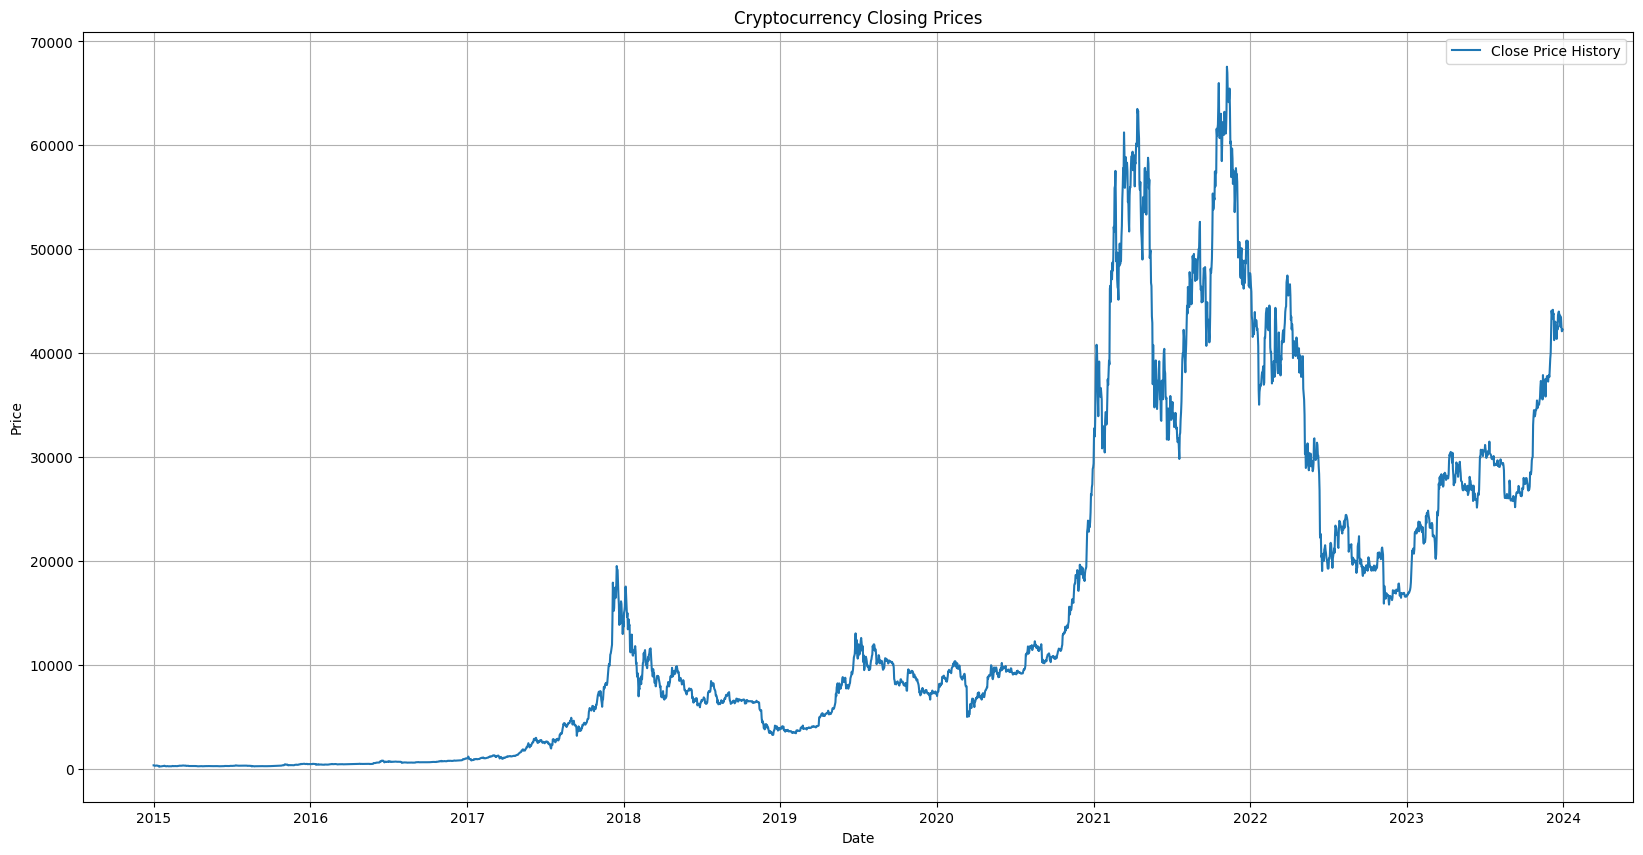

In [6]:
# Sample plot

# Create a new figure for plotting
plt.figure()

# Plot the 'Close' prices from the DataFrame using the index (which represents dates) as the x-axis
# 'label' is used to provide a legend for the plot
plt.plot(df.index, df['Close'], label='Close Price History')

# Set the title of the plot
plt.title('Cryptocurrency Closing Prices')

# Set the label for the x-axis
plt.xlabel('Date')

# Set the label for the y-axis
plt.ylabel('Price')

# Add a legend to the plot, which uses the 'label' provided in the plt.plot() function
plt.legend()

# Add a grid to the plot for better readability
plt.grid(True)

# Display the plot
plt.show()


In [7]:
# Step 2: Prepare data for training

# Sort index
df = df.sort_index(ascending=True)

# Create DataFrame
new_dataset = pd.DataFrame(index=df.index, columns=['Close'])
new_dataset['Close'] = df['Close']

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the scaler on the 'Close' data
scaled_data = scaler.fit_transform(new_dataset[['Close']].values)

# Split the data into training and validation sets
train_data = scaled_data[0:987, :]
valid_data = scaled_data[987:, :]

# Prepare training data for LSTM
x_train_data, y_train_data = [], []

# Create sequences for training data
for i in range(60, len(train_data)):
  x_train_data.append(scaled_data[i-60:i, 0])
  y_train_data.append(scaled_data[i, 0])

# Convert lists to numpy arrays
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# Reshape data to be compatible with LSTM [samples, time steps, features]
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

# Output shapes for verification
print(f"x_train_data shape: {x_train_data.shape}")
print(f"y_train_data shape: {y_train_data.shape}")

x_train_data shape: (927, 60, 1)
y_train_data shape: (927,)


In [8]:
# Step 3: Buid and Train LTSM model

# Initialize the Sequential model
lstm_model = Sequential()

# Add Input layer to specify the input shape
# units=50: Number of LSTM units in this layer
# return_sequences=True: Returns the full sequence of outputs for each input sequence
# Input(shape=(60, 1)) specifies that each input sequence has 60 time steps and 1 feature
lstm_model.add(Input(shape=(x_train_data.shape[1], 1)))

# Add the first LSTM layer
lstm_model.add(LSTM(units=50, return_sequences=True))

# Add the second LSTM layer
# units=50: Number of LSTM units in this layer
# No return_sequences=True: Outputs the last output in the sequence
lstm_model.add(LSTM(units=50))

# Add a Dense layer
# Dense(1): Output layer with 1 unit (predicting a single value)
lstm_model.add(Dense(1))

# Prepare input data for making predictions
# Extract the last part of the new_dataset (for validation) and prepare it for the model
inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60:].values
inputs_data = inputs_data.reshape(-1, 1)  # Reshape for scaling
inputs_data = scaler.transform(inputs_data)  # Normalize using the same scaler

# Compile the model
# loss='mean_squared_error': Loss function to minimize (suitable for regression problems)
# optimizer='adam': Optimization algorithm for updating model weights
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

# Save the trained model to a file
lstm_model.save('saved_model.keras')

927/927 - 11s - 11ms/step - loss: 1.9466e-05


In [9]:
# Prepare input data for prediction
X_test = []
for i in range(60, inputs_data.shape[0]):
  X_test.append(inputs_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict closing prices using the trained model
predicted_closing_price = lstm_model.predict(X_test)

# Inverse transform the predicted values to original scale
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


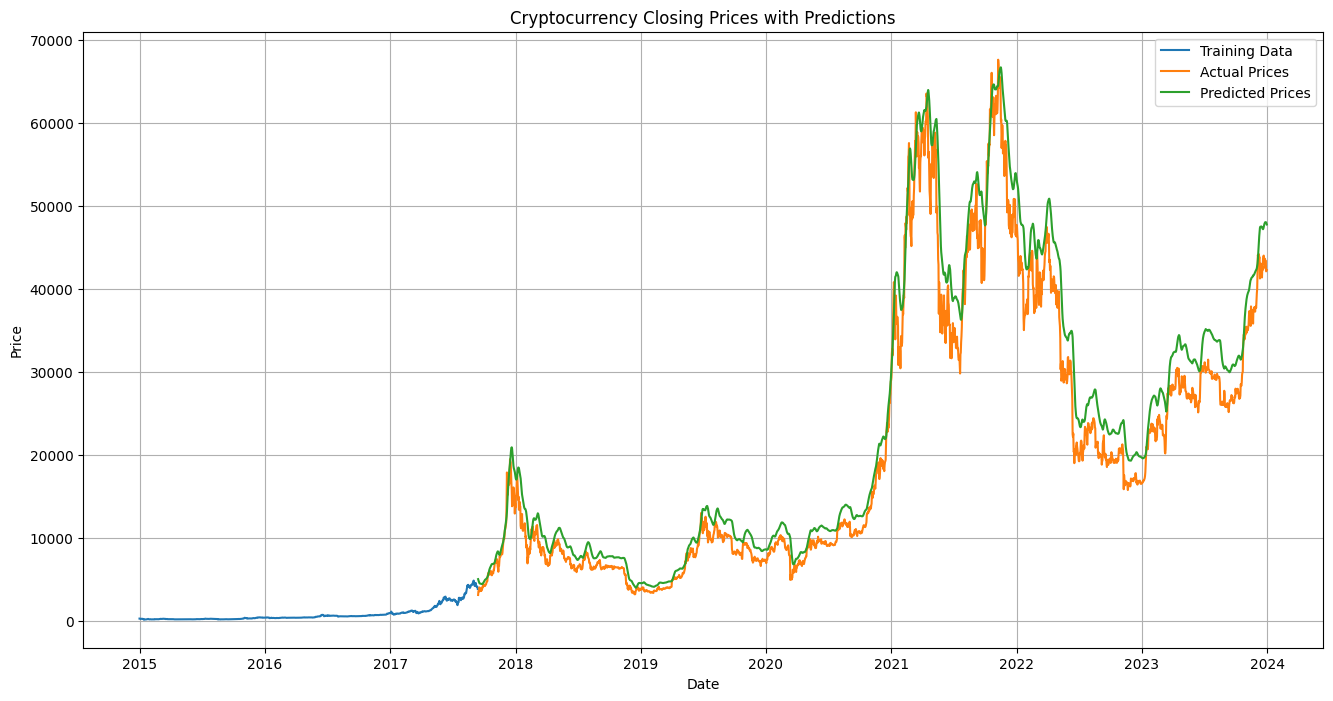

In [10]:
# Define the train and validation datasets
# Split the new_dataset into training and validation sets
# `train_data` contains data from the beginning up to index 987
train_data = new_dataset[:987]

# `valid_data` contains data from index 987 onwards
# Make a deep copy of the slice to avoid modifying a view and causing SettingWithCopyWarning
valid_data = new_dataset[987:].copy()

# Ensure proper DataFrame assignment using .loc
# Assign the predicted closing prices to the 'Predictions' column of valid_data
# This operation avoids the SettingWithCopyWarning by ensuring we are modifying a copy of the DataFrame
valid_data.loc[:, 'Predictions'] = predicted_closing_price

# Plot the data
plt.figure(figsize=(16, 8))  # Set the figure size for better visibility

# Plot the training data 'Close' prices
# `train_data.index` provides the x-axis values (dates), and `train_data['Close']` provides the y-axis values (prices)
plt.plot(train_data.index, train_data['Close'], label='Training Data')

# Plot the actual closing prices from the validation data
# `valid_data.index` provides the x-axis values (dates), and `valid_data['Close']` provides the y-axis values (prices)
plt.plot(valid_data.index, valid_data['Close'], label='Actual Prices')

# Plot the predicted closing prices from the validation data
# `valid_data.index` provides the x-axis values (dates), and `valid_data['Predictions']` provides the y-axis values (predicted prices)
plt.plot(valid_data.index, valid_data['Predictions'], label='Predicted Prices')

# Add titles and labels for better understanding of the plot
plt.title('Cryptocurrency Closing Prices with Predictions')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Price')  # Label for the y-axis

# Add a legend to differentiate between the training data, actual prices, and predicted prices
plt.legend()

# Add a grid to the plot for easier readability of the values
plt.grid(True)

# Display the plot
plt.show()
